In [1]:
import pandas as pd
datafile = pd.read_parquet('/content/data.parquet')


In [2]:
datafile

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [3]:
df = pd.read_parquet('/content/data.parquet')

csv_file_path = 'data_true_beacon.csv'

df.to_csv(csv_file_path, index=False)

In [4]:
# Applying linear interpolation to the 'banknifty' and 'nifty' columns
data_linear_interpolated = datafile[['banknifty', 'nifty','tte']].interpolate(method='linear')

In [5]:
data_linear_interpolated

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27
...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28
2022-06-30 15:27:00,0.240875,0.216558,28
2022-06-30 15:28:00,0.242115,0.216794,28


In [6]:
data = data_linear_interpolated

In [7]:
import pandas as pd
import numpy as np

data['Spread'] = data['banknifty'] - data['nifty']


In [8]:
data['Theoretical P/L'] = data['Spread'] * (data['tte'] ** 0.7)

In [9]:
# Setting the window size to 375 minutes (1 trading day)
window_size = 375

# Calculate the rolling mean and standard deviation for the spread
data['Spread_Mean'] = data['Spread'].rolling(window=window_size).mean()
data['Spread_Std'] = data['Spread'].rolling(window=window_size).std()

In [10]:
# Calculate the Z-Score
data['Z_Score'] = (data['Spread'] - data['Spread_Mean']) / data['Spread_Std']

In [11]:
data['Z_Score'] = data['Z_Score'].fillna(0)

data

,banknifty,nifty,tte,Spread,Theoretical P/L,Spread_Mean,Spread_Std,Z_Score
time,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.867184,NaN,NaN,0.000000
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.853317,NaN,NaN,0.000000
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.846089,NaN,NaN,0.000000
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.866325,NaN,NaN,0.000000
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.869786,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.267320,0.025891,0.001931,0.026985
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.250560,0.025877,0.001924,-0.811114
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.260910,0.025867,0.001916,-0.284789


In [12]:
# Define z-score thresholds for entering and exiting trades
entry_threshold = 0.5
exit_threshold = 0.5

# Initialize a new column for the trading position, defaulting to 0 (no position)
data['Position'] = 0

# Define trading signals based on z-score
# Go Long on the spread (Buy signal) when z-score is less than -entry_threshold
data.loc[data['Z_Score'] < -entry_threshold, 'Position'] = 1

# Go Short on the spread (Sell signal) when z-score is greater than entry_threshold
data.loc[data['Z_Score'] > entry_threshold, 'Position'] = -1

# Close positions (Exit signal) when z-score returns to a range between -exit_threshold and exit_threshold
# This involves setting the position back to 0 when the condition is met
# Since we want to exit regardless of whether we were long or short, we check for the absolute value of the z-score
data.loc[data['Z_Score'].between(-exit_threshold, exit_threshold), 'Position'] = 0

# Display a snippet of the dataframe to verify the positions
data[['Z_Score', 'Position']].tail(10)


,Z_Score,Position
time,,
2022-06-30 15:21:00,-0.433525,0
2022-06-30 15:22:00,-0.540607,1
2022-06-30 15:23:00,-0.143808,0
2022-06-30 15:24:00,-0.444060,0
2022-06-30 15:25:00,-0.380270,0
2022-06-30 15:26:00,0.026985,0
2022-06-30 15:27:00,-0.811114,1
2022-06-30 15:28:00,-0.284789,0
2022-06-30 15:29:00,0.581873,-1


In [13]:
# Step 1: Shift the positions to simulate realistic trade execution
data['Shifted_Position'] = data['Position'].shift(1).fillna(0)

# Step 2: Calculate the P/L for each trade
# We're using the theoretical P/L here as a base; adjust according to your specific P/L calculation needs
data['Trade_P/L'] = data['Shifted_Position'] * data['Theoretical P/L']

# Step 3: Calculate Cumulative P/L
data['Cumulative_Trade_P/L'] = data['Trade_P/L'].cumsum()


In [14]:
def optimize_thresholds(data, entry_range):
    best_total_profit = -np.inf
    optimal_thresholds = {'entry': None, 'exit': None}

    for entry_threshold in entry_range:

            # Calculate positions based on entry and exit thresholds
            data['Position'] = 0
            data.loc[data['Z_Score'] > entry_threshold, 'Position'] = 1  # Short
            data.loc[data['Z_Score'] < -entry_threshold, 'Position'] = -1  # Long
            data.loc[data['Z_Score'].between(-entry_threshold, entry_threshold), 'Position'] = 0  # Exit

            # Shift positions for realistic trade execution
            data['Shifted_Position'] = data['Position'].shift(1).fillna(0)

            # Calculate adjusted Trade P/L
            data['Adjusted_Trade_P/L'] = data['Theoretical P/L'] * data['Shifted_Position']

            # Calculate adjusted Cumulative Trade P/L
            data['Adjusted_Cumulative_Trade_P/L'] = data['Adjusted_Trade_P/L'].cumsum()

            # Evaluate performance
            total_profit = data['Adjusted_Cumulative_Trade_P/L'].iloc[-1]

            # Update best thresholds if current total profit is better
            if total_profit > best_total_profit:
                best_total_profit = total_profit
                optimal_thresholds['entry'] = entry_threshold
                optimal_thresholds['exit'] = -entry_threshold

    return optimal_thresholds, best_total_profit



In [15]:
entry_threshold_range = np.arange(0.0, 20.0, 0.1)

# Execute the grid search
optimal_thresholds, best_total_profit = optimize_thresholds(data, entry_threshold_range)

print(f"Optimal Entry Threshold: {optimal_thresholds['entry']}")
print(f"Optimal Exit Threshold: {optimal_thresholds['exit']}")
print(f"Best Total Adjusted Cumulative P/L: {best_total_profit}")


Optimal Entry Threshold: 1.9000000000000001
Optimal Exit Threshold: -1.9000000000000001
Best Total Adjusted Cumulative P/L: 2196.685339193222


In [16]:
data['Daily_Returns'] = data['Cumulative_Trade_P/L'].pct_change().fillna(0)

In [17]:
def optimize_thresholds_on_cumulative_pl(data, entry_range):
    best_cumulative_pl = -np.inf
    optimal_thresholds = {'entry': None, 'exit': None}

    for entry_threshold in entry_range:

            data['Position'] = 0
            data.loc[data['Z_Score'] > entry_threshold, 'Position'] =  1
            data.loc[data['Z_Score'] < -entry_threshold, 'Position'] = -1
            data.loc[data['Z_Score'].between(-entry_threshold, entry_threshold), 'Position'] = 0

            # Calculate Trade P/L based on Theoretical P/L without adjusting for actual positions held
            data['Trade_P/L'] = data['Theoretical P/L'] * data['Position']

            # Calculate Cumulative Trade P/L
            data['Cumulative_Trade_P/L'] = data['Trade_P/L'].cumsum()

            # Evaluate performance based on Cumulative Trade P/L
            final_cumulative_pl = data['Cumulative_Trade_P/L'].iloc[-1]

            # Update best performance and thresholds
            if final_cumulative_pl > best_cumulative_pl:
                best_cumulative_pl = final_cumulative_pl
                optimal_thresholds['entry'] = entry_threshold
                optimal_thresholds['exit'] = -entry_threshold

    return optimal_thresholds, best_cumulative_pl


In [18]:
# Example ranges - adjust these based on your strategy's characteristics
entry_threshold_range = np.arange(0, 20, 0.5)


In [19]:
# Execute the grid search
optimal_thresholds, best_cumulative_pl = optimize_thresholds_on_cumulative_pl(
    data, entry_threshold_range)

# Print the results
print(f"Optimal Entry Threshold: {optimal_thresholds['entry']}")
print(f"Optimal Exit Threshold: {optimal_thresholds['exit']}")
print(f"Best Cumulative Trade P/L: {best_cumulative_pl}")


Optimal Entry Threshold: 2.0
Optimal Exit Threshold: -2.0
Best Cumulative Trade P/L: 2383.976355898957


In [20]:
data

,banknifty,nifty,tte,Spread,Theoretical P/L,Spread_Mean,Spread_Std,Z_Score,Position,Shifted_Position,Trade_P/L,Cumulative_Trade_P/L,Adjusted_Trade_P/L,Adjusted_Cumulative_Trade_P/L,Daily_Returns
time,,,,,,,,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.867184,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.853317,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.846089,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.866325,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.869786,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.267320,0.025891,0.001931,0.026985,0,0.0,0.0,0.0,0.0,0.0,0.000000
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.250560,0.025877,0.001924,-0.811114,0,0.0,0.0,0.0,0.0,0.0,0.000000
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.260910,0.025867,0.001916,-0.284789,0,0.0,0.0,0.0,0.0,0.0,0.000131


In [21]:
data

,banknifty,nifty,tte,Spread,Theoretical P/L,Spread_Mean,Spread_Std,Z_Score,Position,Shifted_Position,Trade_P/L,Cumulative_Trade_P/L,Adjusted_Trade_P/L,Adjusted_Cumulative_Trade_P/L,Daily_Returns
time,,,,,,,,,,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.867184,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.853317,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.846089,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.866325,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.869786,NaN,NaN,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.267320,0.025891,0.001931,0.026985,0,0.0,0.0,0.0,0.0,0.0,0.000000
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.250560,0.025877,0.001924,-0.811114,0,0.0,0.0,0.0,0.0,0.0,0.000000
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.260910,0.025867,0.001916,-0.284789,0,0.0,0.0,0.0,0.0,0.0,0.000131


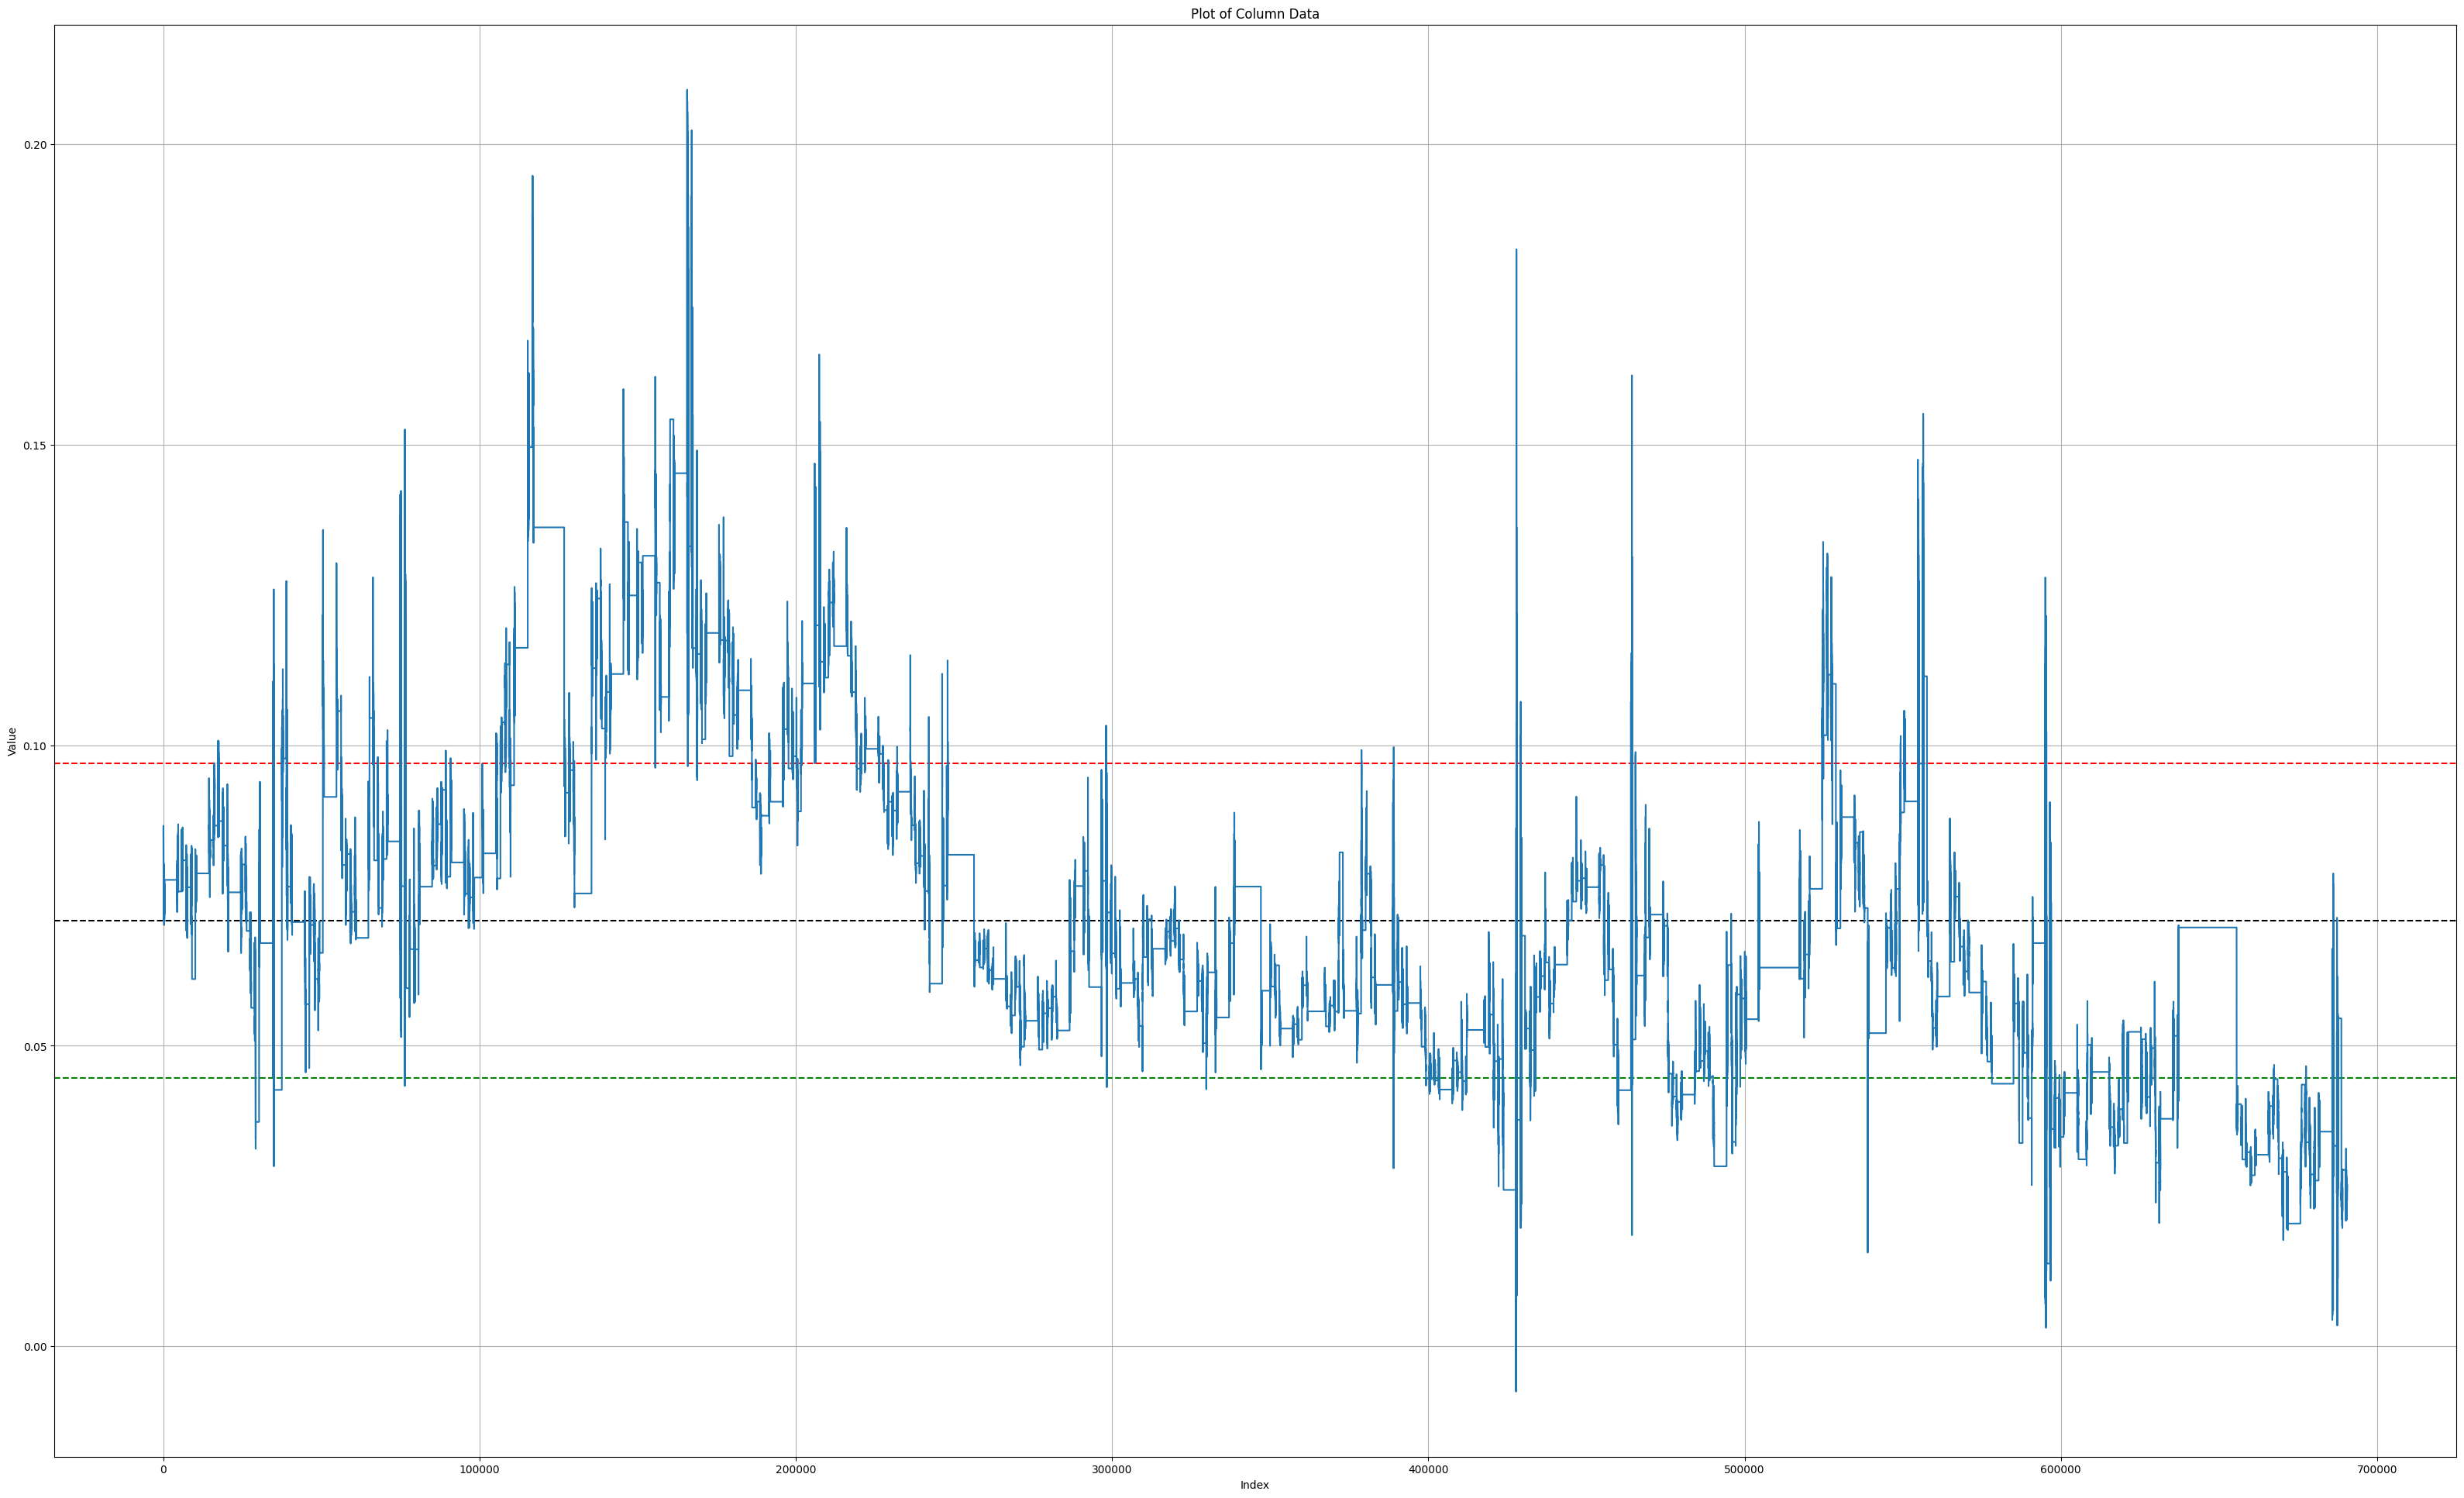

In [27]:
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named data
# Load your data into the DataFrame
# Example:
# data = pd.read_csv('your_data.csv')

# Extract the column of data you want to plot
y_values = data['Spread']

# Define the x-axis values as a sequence of consecutive integers
x_values = range(len(y_values))
plt.figure(figsize=(40, 24))
mean_value = data['Spread'].mean()
st = data['Spread'].std()
# Plot the mean line
plt.axhline(mean_value, color='black', linestyle='--', label='Mean')
plt.axhline(mean_value+st, color='red', linestyle='--', label='Mean')
plt.axhline(mean_value-st, color='green', linestyle='--', label='Mean')
# Plot the data
plt.plot(x_values, y_values)

# Add labels and title

plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Plot of Column Data')

# Show the plot
plt.grid(True)
plt.show()


In [23]:
mx = data['Z_Score'].max()
mn = data['Z_Score'].min()
print(mx)
print(mn)

19.3132874534755
-19.31332090876673


In [39]:
df = data[['banknifty',	'nifty'	, 'tte'	, 'Spread','Theoretical P/L']].copy()
df

,banknifty,nifty,tte,Spread,Theoretical P/L
time,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.867184
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.853317
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.846089
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.866325
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.869786
...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.267320
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.250560
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.260910


# As we can see that from the graph there exist outliers in the data, so one hypothesis could be using robust z_score which is less sensitive to outliers

In [71]:
import numpy as np
import pandas as pd

# Define the rolling MAD function
def rolling_mad(x):
    return np.median(np.abs(x - np.median(x)))



# Calculate the rolling window median
df['spread_median'] = df['Spread'].rolling(window=window_size).median()
df['spread_median'].fillna(0, inplace=True)

# Calculate the rolling window MAD using the custom function
df['mad'] = df['Spread'].rolling(window=window_size).apply(rolling_mad, raw=True)
df['mad'].fillna(0, inplace=True)

# Calculate the robust z-score for the rolling window
df['z_robust'] = (df['Spread'] - df['spread_median']) / df['mad']

# Print the DataFrame
print(df)


                     banknifty     nifty  tte    Spread  Theoretical P/L  \
time                                                                       
2021-01-01 09:15:00   0.286058  0.199729   27  0.086329         0.867184   
2021-01-01 09:16:00   0.285381  0.200433   27  0.084948         0.853317   
2021-01-01 09:17:00   0.284233  0.200004   27  0.084229         0.846089   
2021-01-01 09:18:00   0.286104  0.199860   27  0.086244         0.866325   
2021-01-01 09:19:00   0.285539  0.198951   27  0.086588         0.869786   
...                        ...       ...  ...       ...              ...   
2022-06-30 15:26:00   0.240701  0.214758   28  0.025943         0.267320   
2022-06-30 15:27:00   0.240875  0.216558   28  0.024317         0.250560   
2022-06-30 15:28:00   0.242115  0.216794   28  0.025321         0.260910   
2022-06-30 15:29:00   0.243426  0.216455   28  0.026971         0.277912   
2022-06-30 15:30:00   0.241907  0.216081   28  0.025827         0.266124   

           

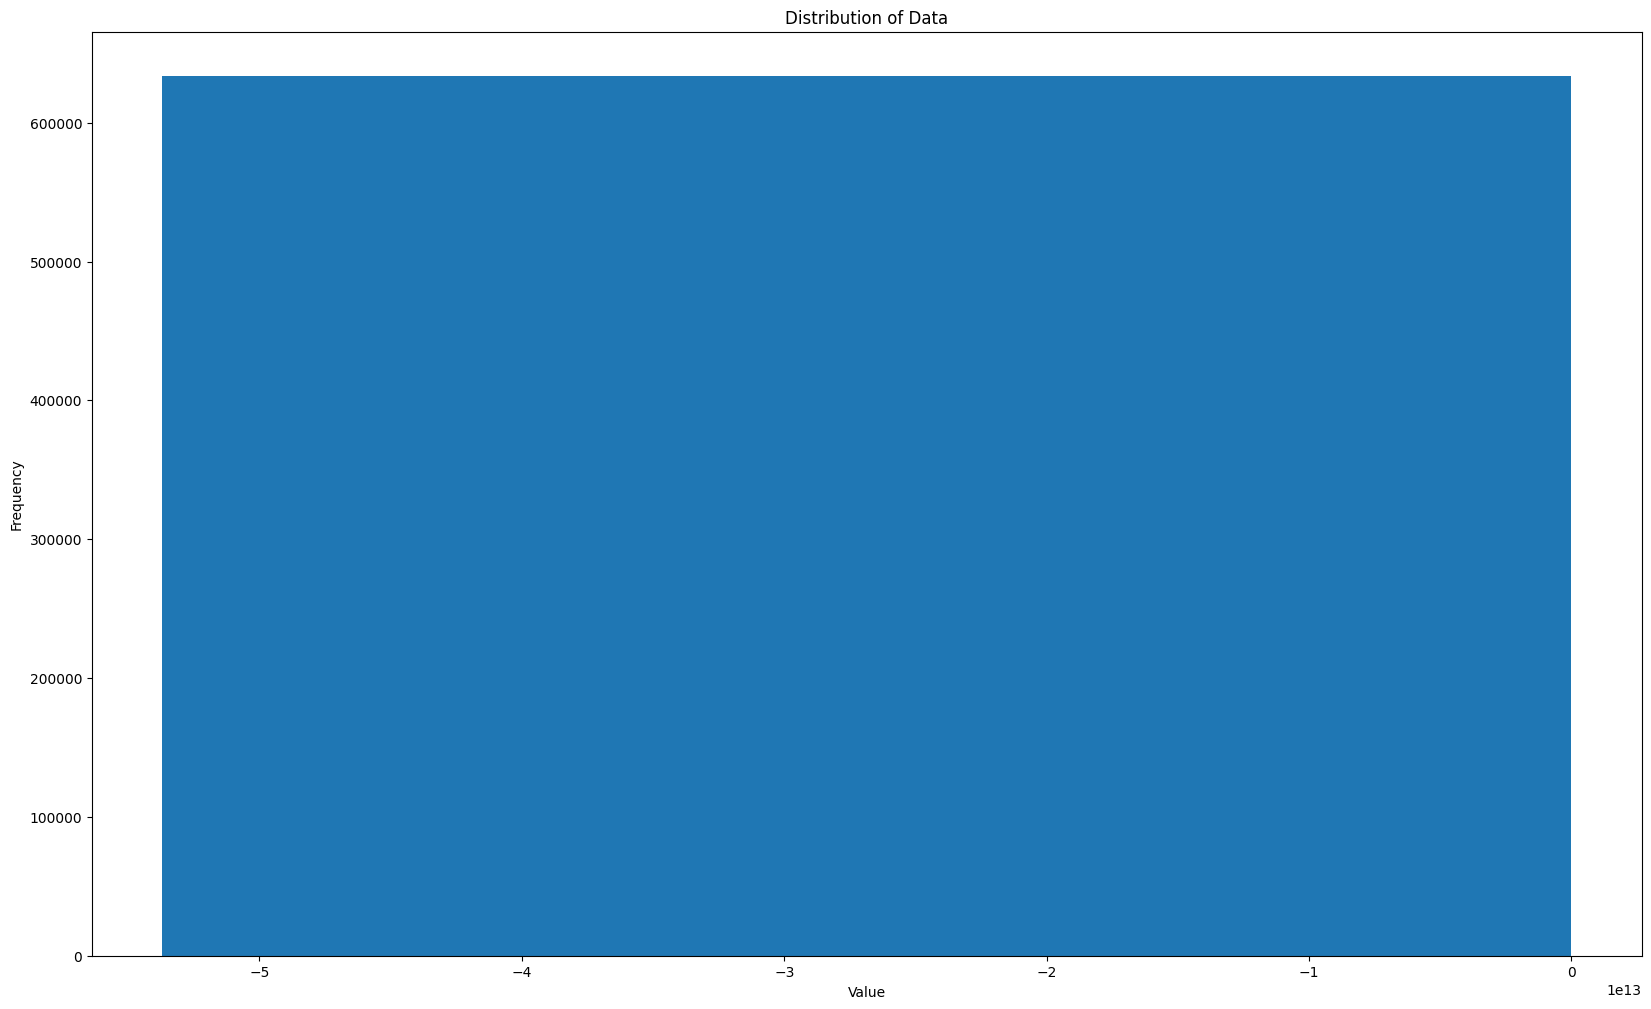

In [72]:
df['mad'].fillna(0, inplace=True)
df['z_robust'].fillna(0, inplace=True)

# Plot histogram with filtering out infinite values
plt.figure(figsize=(20,12))
plt.hist(df['z_robust'][np.isfinite(df['z_robust'])], bins=1)  # Adjust the number of bins as needed

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Data')
plt.show()

In [73]:
print(df['z_robust'].min())
print(df['mad'].min())

-inf
0.0


In [62]:
df['position'] = 0
def thresholds(df, entry_range):
    best_cumulative_pl = -np.inf
    optimal_thresholds = {'entry': None, 'exit': None}

    for entry_threshold in entry_range:

            df['Position'] = 0
            df.loc[df['z_robust'] > entry_threshold, 'Position'] =  1
            df.loc[df['z_robust'] < -entry_threshold, 'Position'] = -1
            df.loc[df['z_robust'].between(-entry_threshold, entry_threshold), 'Position'] = 0

            # Calculate Trade P/L based on Theoretical P/L without adjusting for actual positions held
            df['Trade_P/L'] = df['Theoretical P/L'] * df['Position']

            # Calculate Cumulative Trade P/L
            df['Cumulative_Trade_P/L'] = df['Trade_P/L'].cumsum()

            # Evaluate performance based on Cumulative Trade P/L
            final_cumulative_pl = df['Cumulative_Trade_P/L'].iloc[-1]

            # Update best performance and thresholds
            if final_cumulative_pl > best_cumulative_pl:
                best_cumulative_pl = final_cumulative_pl
                optimal_thresholds['entry'] = entry_threshold
                optimal_thresholds['exit'] = -entry_threshold

    return optimal_thresholds, best_cumulative_pl


In [63]:
range = np.arange(0,10,0.1)


In [64]:
thresholds, best_pl = thresholds(df, entry_range)

# Print the results
# print(f"Optimal Entry Threshold: {thresholds['entry']}")
# print(f"Optimal Exit Threshold: {thresholds['exit']}")
print(f"Best Cumulative Trade P/L: {best_pl}")

Best Cumulative Trade P/L: 7158.997394276404
